20211102_S2B3R3E-f_ref


C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


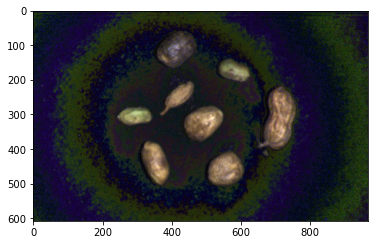

In [115]:
#%%
from scipy.signal import medfilt
from spectral import imshow, view_cube
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from PIL import Image
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from skimage import measure
from sklearn.utils import resample
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
from scipy.spatial import distance
from pathlib                 import Path
import glob
from sklearn.metrics import pairwise_distances


plt.close('all')
path = glob.glob(r'./Train_Data/HSI_Data/*')
filename=path[0][path[0].rfind('\\')+1:]
print(filename)
img_rgb = Image.open(os.path.join(path[0], filename+'.png')).convert('RGB')
img_rgb_ar = np.array(img_rgb)
view_rgb = imshow(img_rgb_ar)
hsi_ref = envi.open(os.path.join(path[0], filename+'.hdr'),\
                      os.path.join(path[0], filename+'.dat'))
hsi_np = hsi_ref.asarray()
Mask = np.load('./Train_Data/Valid_Mask/'+filename+'.npy')
print(Mask.astype(int))

In [116]:
#%% filtering the peanut spectra with 1x5 convolutional filter
row,col = np.where(Mask==1)
hsi_p=hsi_np[row,col]
hsi_filtered=np.zeros((len(hsi_p),299))

rand_np = np.copy(hsi_np)
for i in range(len(hsi_p)):
    rand_np[row[i],col[i]] = medfilt(hsi_np[row[i],col[i]],5)

In [117]:
#%% Normalize the peanut spectra
for i in range(len(row)):
    rand_np[row[i],col[i]]=(rand_np[row[i],col[i]]-min(rand_np[row[i],col[i]]))/(max(rand_np[row[i],col[i]])-min(rand_np[row[i],col[i]]))


 
Change in Objective Function Value: inf
Minimum of Maximum Proportions: 0.9999999999998532
Number of Endmembers: 20
Iteration: 1
 
 
Change in Objective Function Value: 42.06873546139758
Minimum of Maximum Proportions: 2.3389348937385395e-15
Number of Endmembers: 17
Iteration: 2
 
 
Change in Objective Function Value: 59.29470477062395
Minimum of Maximum Proportions: 0.0
Number of Endmembers: 13
Iteration: 3
 
 
Change in Objective Function Value: 15.615965294935194
Minimum of Maximum Proportions: 5.6669442031125365e-14
Number of Endmembers: 12
Iteration: 4
 
 
Change in Objective Function Value: 30.607786795857862
Minimum of Maximum Proportions: 4.159537885766626e-15
Number of Endmembers: 10
Iteration: 5
 
 
Change in Objective Function Value: 15.500115073656872
Minimum of Maximum Proportions: 2.798086580049291e-15
Number of Endmembers: 9
Iteration: 6
 
 
Change in Objective Function Value: 0.24076679286258695
Minimum of Maximum Proportions: 0.7976435906056736
Number of Endmembers: 

Text(0.5, 1.0, 'SPICE Endmembers')

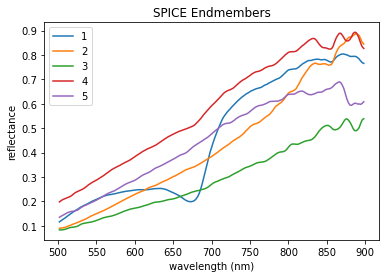

In [4]:
#%%
from Model import *
import matplotlib.pyplot as plt


# def main():

# load the data from the pickle file

valid_mask=Mask.astype(bool)
# trim the noisy bands
hsi_image = rand_np[:,:,50:-50]
x_ax=np.linspace(402,998,299)
x_ax=x_ax[50:-50]
img_shape = hsi_image.shape
n_r, n_c, n_b = hsi_image.shape

# load the wavelength information

# reshape the data because SPICE takes an MxN array, not a full HSI cube
hsi_image = np.reshape(hsi_image, (img_shape[0]*img_shape[1], img_shape[2]))
valid_array = np.reshape(valid_mask, (img_shape[0]*img_shape[1],))
# take the hsi data at the "valid" points
M = hsi_image[valid_array, :]

# since analyzing the image will take a long time, we will down sample the data for the sake of this demo
input_data = M.T.astype(float)
ds_data = input_data[:, ::20] 

# get the default parameters from the SPICE.py file
params = SPICEParameters()
params.qp_solver = 'QPP'
params.gamma=10
params.u=0.1
# run the spice algorithm on the down sampled data
[endmembers, ds_proportions] = SPICE(ds_data, params)

# prompt the user to see if they would like to graph the output
# if input('Would you like to plot the output? (Y/n): ') == 'n':
#     return

# plot the wavelength versus the reflectance
n_em = endmembers.shape[1]
plt.plot(x_ax, endmembers)
plt.xlabel('wavelength (nm)')
plt.ylabel('reflectance')
plt.legend([str(i + 1) for i in range(n_em)])
plt.title('SPICE Endmembers')

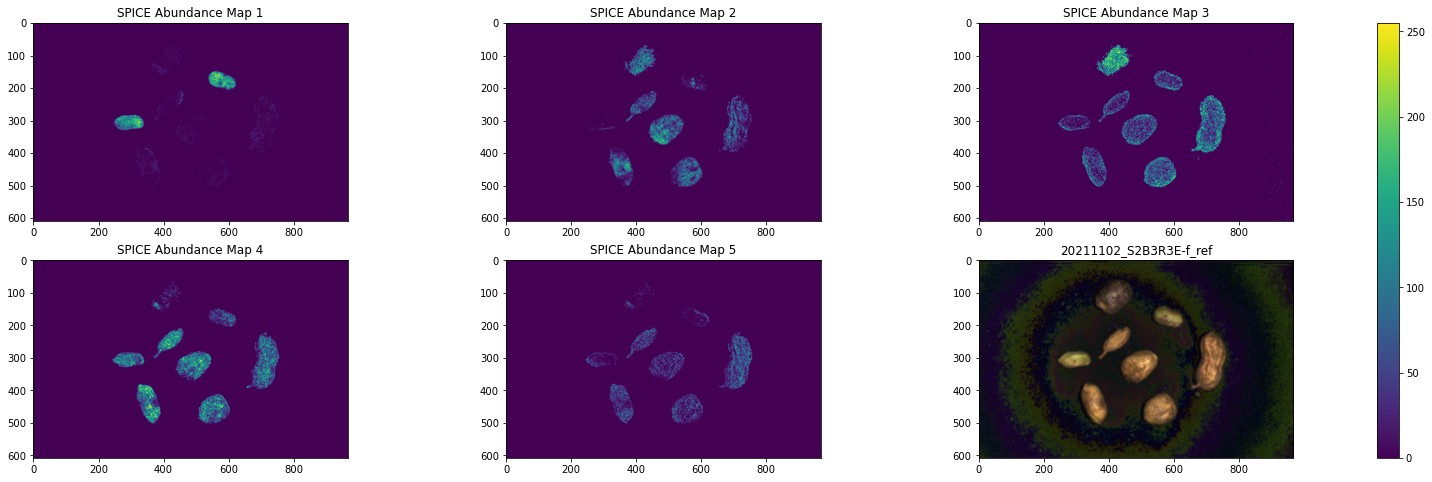

In [5]:
#%%

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 28 10:58:03 2020

@author: weihuang
"""
# load the data from the pickle file

valid_mask=Mask.astype(bool)
# trim the noisy bands
hsi_image = rand_np[:,:,50:-50]
x_ax=np.linspace(402,998,299)
x_ax=x_ax[50:-50]
img_shape = hsi_image.shape
n_r, n_c, n_b = hsi_image.shape

# load the wavelength information

# reshape the data because SPICE takes an MxN array, not a full HSI cube
hsi_image = np.reshape(hsi_image, (img_shape[0]*img_shape[1], img_shape[2]))
valid_array = np.reshape(valid_mask, (img_shape[0]*img_shape[1],))
# take the hsi data at the "valid" points
M = hsi_image[valid_array, :]

# since analyzing the image will take a long time, we will down sample the data for the sake of this demo
input_data = M.T.astype(float)
ds_data = input_data[:, ::20]

# unmix the data using the non-downsampled array and the endmembers that SPICE discovered


if params.qp_solver == 'cvxopt':
    P = unmix_cvxopt(input_data, endmembers)
else:
    scaler = input_data.max()
    P = unmix_qpp(input_data/scaler,endmembers/scaler)

# re-ravel abundance maps
P_imgs = []
for i in range(n_em):
    map_lin = np.zeros((n_r * n_c,))
    map_lin[valid_array] = P[:, i]
    P_imgs.append(np.reshape(map_lin, (n_r, n_c)))

# display abundance maps in the form of a subplot

fig, axes = plt.subplots(2, int(n_em/2) + 1, squeeze=True,figsize=(30,8))

for i in range(n_em):
    im = axes.flat[i].imshow(P_imgs[i], vmin=0, vmax=1)
    axes.flat[i].set_title('SPICE Abundance Map %d' % (i + 1))

# add the original RGB image to the subplot
im = axes.flat[n_em].imshow(img_rgb_ar)
axes.flat[n_em].set_title(filename)
fig.colorbar(im, ax=axes.ravel().tolist())

# delete any empty subplots
if (n_em % 2 == 0):
    fig.delaxes(axes.flatten()[(2*(int(n_em/2)+1)) -1])
# plt.savefig(filename+'.jpg')
plt.show()


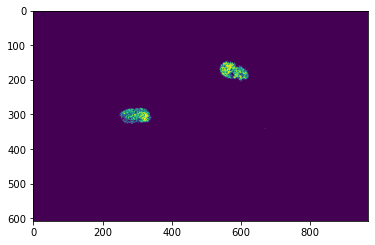

In [6]:
p1=np.copy(P_imgs[0])
p1[p1>=0.5]=1
p1[p1<0.5]=0
plt.imshow(p1)
# p2=np.copy(P_imgs[2])
# p2[p2>=0.5]=1
# p2[p2<0.5]=0
# plt.imshow(p2)
p=p1
plt.imshow(p)

In [7]:
r_p,c_p=np.where(p==1)
pb=rand_np[r_p,c_p]
np.shape(pb)

(3531, 299)

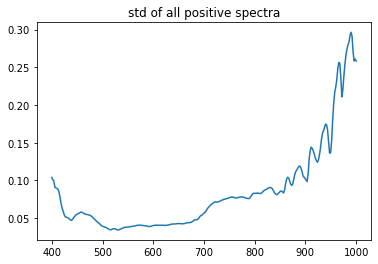

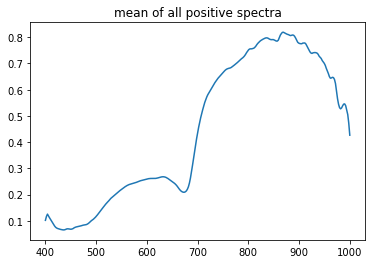

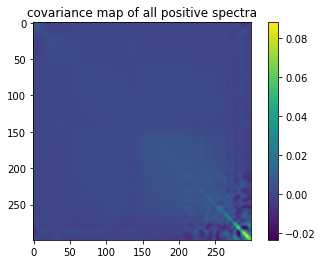

In [8]:
plt.plot(np.linspace(400,1000,len(np.std(pb,axis=0))),np.std(pb,axis=0))
plt.title('std of all positive spectra')
plt.show()
plt.plot(np.linspace(400,1000,len(np.mean(pb,axis=0))),np.mean(pb,axis=0))
plt.title('mean of all positive spectra')
plt.show()
plt.imshow(np.cov(pb.T))
plt.colorbar()
plt.title('covariance map of all positive spectra')
plt.show()

In [9]:
positive_bags=np.array_split(pb[0:3408],200)
np.shape(positive_bags)

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(200,)

In [10]:
means_pos_bag=np.zeros((200,299))
for i in range(len(positive_bags)):
    means_pos_bag[i,:]=np.mean(positive_bags[i],axis=0)

In [ ]:
for i in range(len(positive_bags)):
    plt.plot(np.mean(positive_bags[i],axis=0))
    if (i%10==0):
        plt.show()

Text(0, 0.5, 'Reflectance')

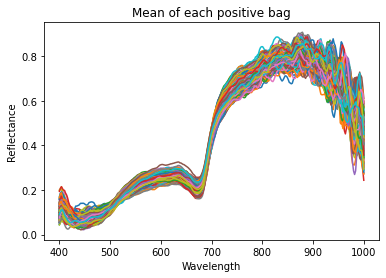

In [15]:
for i in range(len(positive_bags)):
    plt.plot(np.linspace(400,1000,len(np.mean(positive_bags[i],axis=0))),np.mean(positive_bags[i],axis=0))
plt.title('Mean of each positive bag')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')

Text(0, 0.5, 'Reflectance')

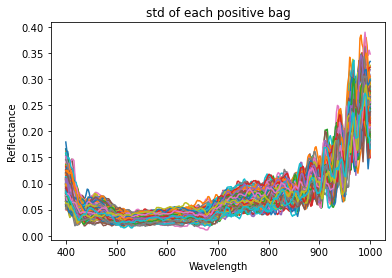

In [17]:
for i in range(len(positive_bags)):
    plt.plot(np.linspace(400,1000,len(np.std(positive_bags[i],axis=0))),np.std(positive_bags[i],axis=0))
plt.title('std of each positive bag')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')

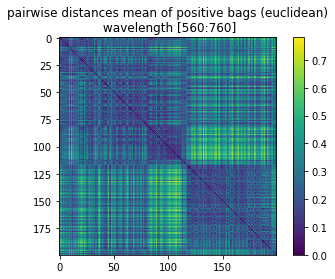

In [92]:
import sklearn
plt.imshow(sklearn.metrics.pairwise_distances(means_pos_bag[:,80:-120],metric='euclidean'))
plt.title('pairwise distances mean of positive bags (euclidean)\n wavelength [560:760]')
plt.colorbar()
plt.show()

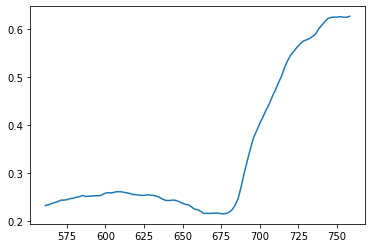

In [48]:
x=np.linspace(400,1000,len(means_pos_bag[0]))
plt.plot(x[80:-120],means_pos_bag[0,80:-120])

(31541, 299)

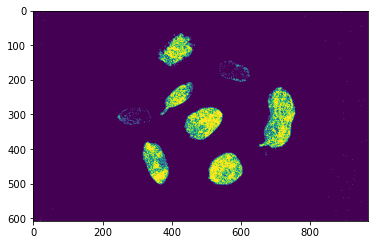

In [93]:
neg=P_imgs[3]+P_imgs[1]+P_imgs[2]+P_imgs[4]
neg[neg>=0.999999]=1
neg[neg<0.999999]=0
plt.imshow(neg)
r_n,c_n=np.where(neg==1)
nb=rand_np[r_n,c_n]
np.shape(nb)

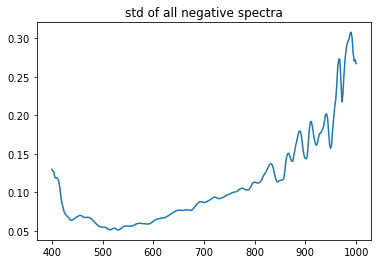

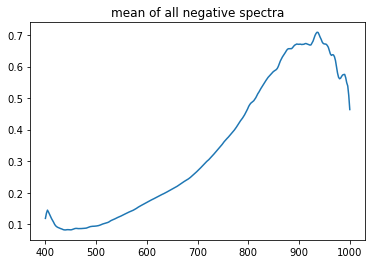

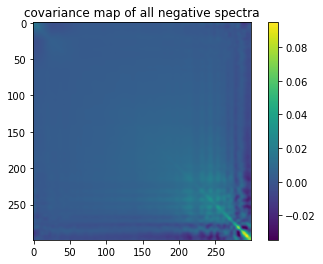

In [78]:
plt.plot(np.linspace(400,1000,len(np.std(nb[0:3828],axis=0))),np.std(nb[0:3828],axis=0))
plt.title('std of all negative spectra')
plt.show()
plt.plot(np.linspace(400,1000,len(np.mean(nb[0:3828],axis=0))),np.mean(nb[0:3828],axis=0))
plt.title('mean of all negative spectra')
plt.show()
plt.imshow(np.cov(nb[0:3828].T))
plt.colorbar()
plt.title('covariance map of all negative spectra')
plt.show()

In [79]:
negative_bags=np.array_split(nb[0:3828],200)
np.shape(negative_bags)

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(200,)

In [80]:
means_neg_bag=np.zeros((200,299))
for i in range(len(negative_bags)):
    means_neg_bag[i,:]=np.mean(negative_bags[i],axis=0)

Text(0, 0.5, 'Reflectance')

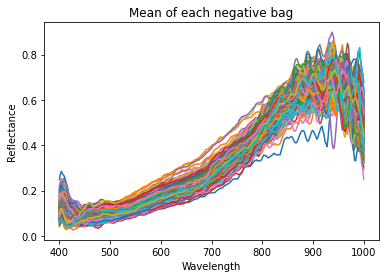

In [81]:
for i in range(len(negative_bags)):
    plt.plot(np.linspace(400,1000,len(np.mean(negative_bags[i],axis=0))),np.mean(negative_bags[i],axis=0))
plt.title('Mean of each negative bag')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')

Text(0, 0.5, 'Reflectance')

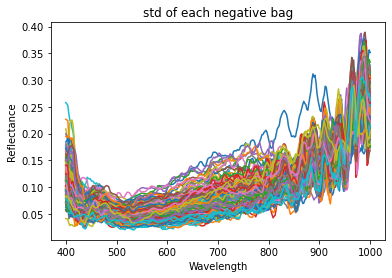

In [82]:
for i in range(len(negative_bags)):
    plt.plot(np.linspace(400,1000,len(np.std(negative_bags[i],axis=0))),np.std(negative_bags[i],axis=0))
plt.title('std of each negative bag')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')

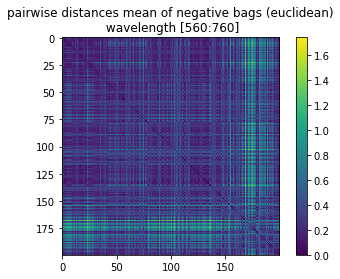

In [83]:
import sklearn
plt.imshow(sklearn.metrics.pairwise_distances(means_neg_bag[:,80:-120],metric='euclidean'))
plt.title('pairwise distances mean of negative bags (euclidean)\n wavelength [560:760]')
plt.colorbar()
plt.show()

In [84]:
bags=np.array([])
bags=np.append(bags,np.asarray(positive_bags))
bags=np.append(bags,np.asarray(negative_bags))
np.shape(bags)

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(400,)

In [94]:
labels=np.zeros((1,400))

labels[0,0:200]=1

In [118]:
labels_test=p
labels_test[r_n,c_n]=0
labels_test=np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1],))
labels_test.shape

(588544,)

------------ Spectral Matched Filter -------------
Whitening...
Initializing with exhaustive_init...


C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Optimizing...
Detecting SMF...
------------ Adaptive Cosine Estimator -------------
Whitening...
Initializing with exhaustive_init...


c:\Users\k.hamad\Desktop\UF\PhD\Codes\Detection\miace\mi_target.py:233: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  denom = np.array([np.reshape(denom[bag], (denom[bag].shape[0], 1)) for bag in range(m_scale.shape[0])])


Optimizing...
Detecting ACE...

Plotting Target Concept and ROC Curve...


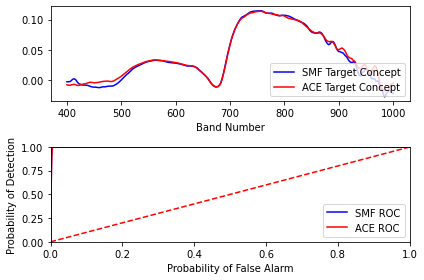

In [119]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from miace.detectors import ace_det, smf_det
from miace.mi_target import mi_target

results = {'smf': {}, 'ace': {}}

parameters = {
    "global_background_flag": False,
    "pos_label": 1,
    "neg_label": 0,
    "max_iter": 100,
    "init_type": 1,
	"init_k": 1000
}

example_data = np.load('datasets/simple_example_data.npz')

# to accomodate bags of difference sizes
bag_list = [example_data['data_bags'][i] for i in range(example_data['data_bags'].shape[0])]

#to test whether the methods work on different sizes. combining a few bags together to create uneven bags
bag_list[0] = np.vstack((bag_list[0], bag_list[1]))
bag_list.pop(1)
labels = np.delete(example_data['labels'], 1, 1)

# SMF init1
print('------------ Spectral Matched Filter -------------')
parameters['method_flag'] = False
parameters['sample_por'] = 1
labels=np.zeros((1,400))
labels[0,0:200]=1


smf_opt_target, _, b_mu, sig_inv_half, _ = mi_target(np.asarray(bags), labels, parameters)

print('Detecting SMF...')

smf_data, _, _ = smf_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
# ACE init 1
print('------------ Adaptive Cosine Estimator -------------')
parameters['method_flag'] = True
parameters['sample_por'] = 1


ace_opt_target, _, b_mu, sig_inv_half, _ = mi_target(np.asarray(bags), labels, parameters)

print('Detecting ACE...')

ace_data, _, _ = ace_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))

print('\nPlotting Target Concept and ROC Curve...')

# Get false and true positive rate
labels_point_test = labels_test

smf_fpr, smf_tpr, smf_threshold = roc_curve(labels_point_test, smf_data, pos_label=1)
ace_fpr, ace_tpr, ace_threshold = roc_curve(labels_point_test, ace_data, pos_label=1)


f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)

# Target Concept
ax1.plot(np.linspace(400,1000,len(smf_opt_target)),smf_opt_target, 'b', label='SMF Target Concept')
ax1.plot(np.linspace(400,1000,len(ace_opt_target)),ace_opt_target, 'r', label='ACE Target Concept')
ax1.legend(loc='lower right')
ax1.set_xlabel('Band Number')

# ROC
ax2.plot(smf_fpr, smf_tpr, 'b', label='SMF ROC')
ax2.plot(ace_fpr, ace_tpr, 'r', label='ACE ROC')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.legend(loc='lower right')
ax2.set_xlabel('Probability of False Alarm')
ax2.set_ylabel('Probability of Detection')

ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

Detecting SMF...
Detecting ACE...


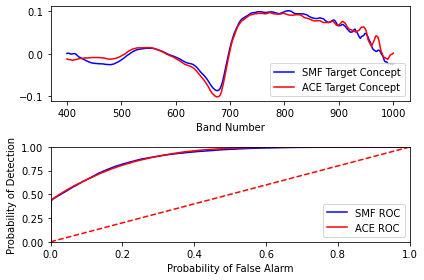

In [43]:
print('Detecting SMF...')
# smf_data, _, _ = smf_det(example_data['x_test'], smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
smf_data, _, _ = smf_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
print('Detecting ACE...')
# ace_data, _, _ = ace_det(example_data['x_test'], ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
ace_data, _, _ = ace_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
labels_point_test = labels_test

smf_fpr, smf_tpr, smf_threshold = roc_curve(labels_point_test, smf_data, pos_label=1)
ace_fpr, ace_tpr, ace_threshold = roc_curve(labels_point_test, ace_data, pos_label=1)


f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)

# Target Concept
ax1.plot(np.linspace(400,1000,len(smf_opt_target)),smf_opt_target, 'b', label='SMF Target Concept')
ax1.plot(np.linspace(400,1000,len(ace_opt_target)),ace_opt_target, 'r', label='ACE Target Concept')
ax1.legend(loc='lower right')
ax1.set_xlabel('Band Number')

# ROC
ax2.plot(smf_fpr, smf_tpr, 'b', label='SMF ROC')
ax2.plot(ace_fpr, ace_tpr, 'r', label='ACE ROC')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.legend(loc='lower right')
ax2.set_xlabel('Probability of False Alarm')
ax2.set_ylabel('Probability of Detection')

ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('train ROC')
plt.show()



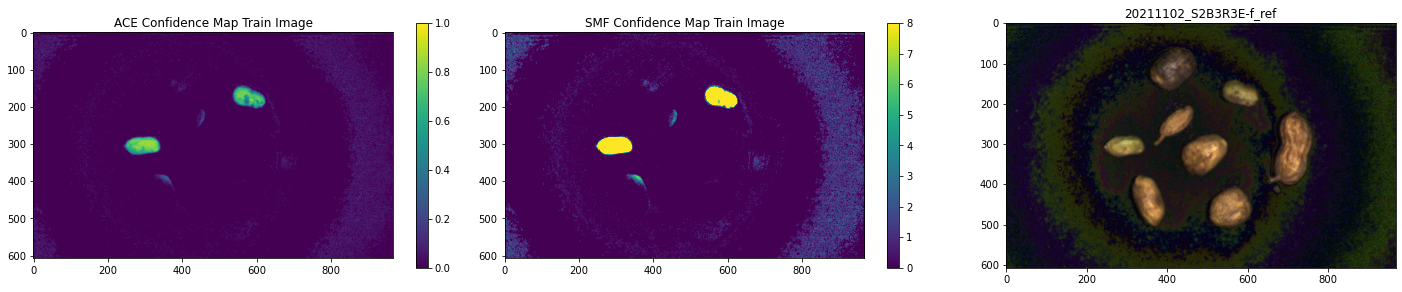

In [120]:
ace_data=np.reshape(ace_data,(608,968))
smf_data=np.reshape(smf_data,(608,968))
fig, ax = plt.subplots(1, 3,figsize=(20,4),squeeze=True)


im = ax[0].imshow(ace_data,vmin=0, vmax=1)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('ACE Confidence Map Train Image')
im = ax[1].imshow(smf_data,vmin=0, vmax=8)
plt.colorbar(im, ax=ax[1])
ax[1].set_title('SMF Confidence Map Train Image')
im = ax[2].imshow(img_rgb)
ax[2].set_title(filename)
plt.tight_layout()


In [640]:
# np.save(r'./smf_opt_target_E1.npy',smf_opt_target)
# np.save(r'./ace_opt_target_E1.npy',ace_opt_target)

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


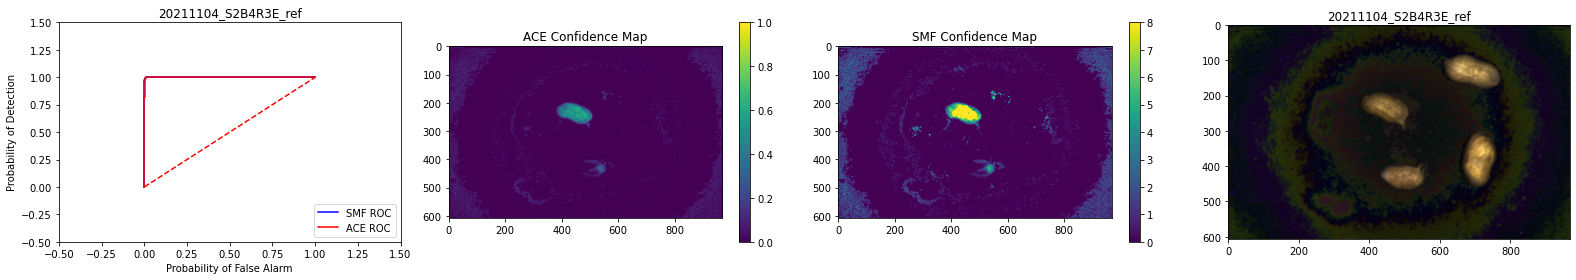

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


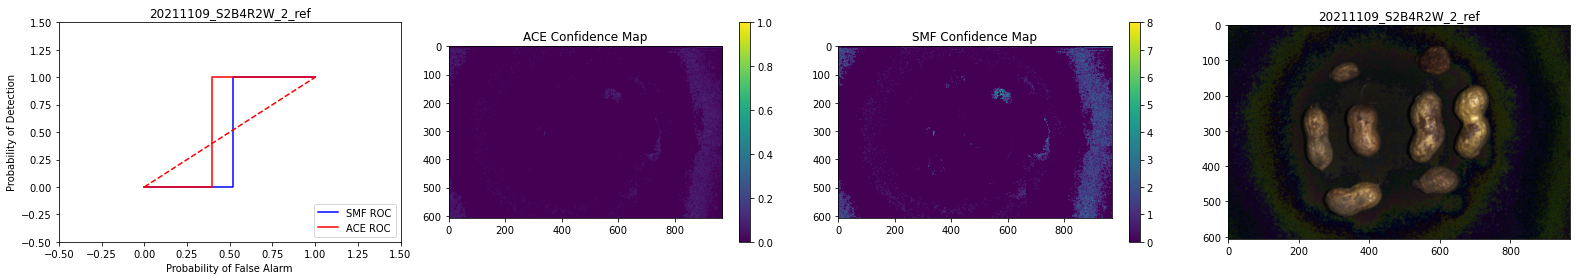

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


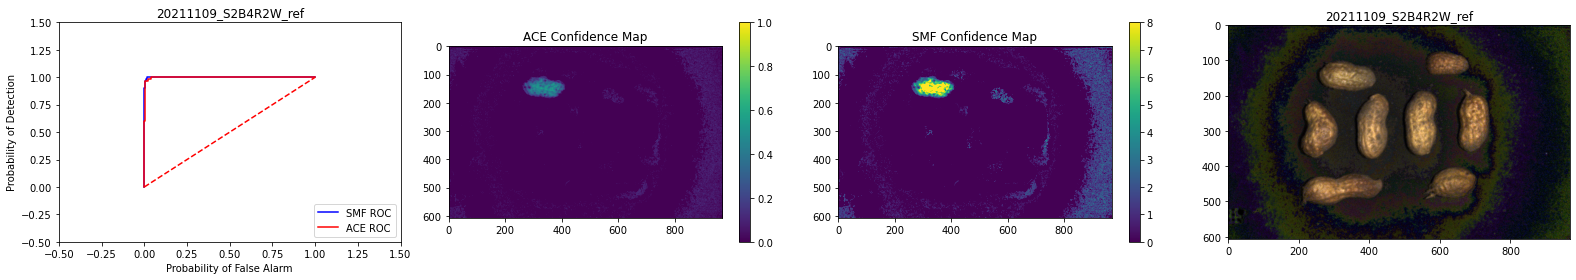

In [114]:
pathse=glob.glob(r'U:\AT\Data\lab_HSI\Greenhouse_202111\Reflectance folders\*')
count=1


# ace_opt_target=np.load(r'.\Opt_Target\ace_opt_target_E1.npy')
# smf_opt_target=np.load(r'.\Opt_Target\smf_opt_target_E1.npy')


count=1
for i in pathse:
    # if (count==9):
    #     break
    filename=i[i.rfind('\\')+1:]
    if(filename!='20211109_S2B4R2W_ref' and
    # filename!='20211109_S2B4R2W_4_ref' and
    #  filename!='20211109_S2B4R2W_3_ref' and
       filename!='20211109_S2B4R2W_2_ref' and
    #    filename!='20211109_S2B4R2E-f_3_ref' and
    #     filename!='20211109_S2B3R2E_4_ref'and
    #      filename!='20211109_S2B3R2E-f_ref'and
    #       filename!='20211109_S2B3R2E-f_4_ref'and
            filename!='20211104_S2B4R3E_ref'):
        continue

    hsi_ref = envi.open(os.path.join(i,filename+'.hdr'),\
                          os.path.join(i,filename+'.dat'))
    hsi_np = hsi_ref.asarray()
    img_rgb = Image.open(os.path.join(i, filename+'.png')).convert('RGB')
    Mask_test = np.load(os.path.join(r'U:\AT\Data\lab_HSI\Greenhouse_202111\Masks',filename+'.npy'))
 
    #%% filtering the peanut spectra with 1x5 convolutional filter
    row,col = np.where(Mask==1)
    hsi_p=hsi_np[row,col]
    hsi_filtered=np.zeros((len(hsi_p),299))

    rand_np_test = np.copy(hsi_np)
    for i in range(len(hsi_p)):
        rand_np_test[row[i],col[i]] = medfilt(hsi_np[row[i],col[i]],5)
    #%% Normalize the peanut spectra
    for i in range(len(row)):
        rand_np_test[row[i],col[i]]=(rand_np_test[row[i],col[i]]-min(rand_np_test[row[i],col[i]]))/(max(rand_np_test[row[i],col[i]])-min(rand_np_test[row[i],col[i]]))
    
    
    labels_test=Mask_test
    labels_test[r_n,c_n]=0
    labels_test=np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1],))
    labels_test.shape
    
    smf_data, _, _ = smf_det(np.reshape(rand_np_test,(rand_np_test.shape[0]*rand_np_test.shape[1],rand_np_test.shape[2])).T, smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
    ace_data, _, _ = ace_det(np.reshape(rand_np_test,(rand_np_test.shape[0]*rand_np_test.shape[1],rand_np_test.shape[2])).T, ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
    
    
    #%%

    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Sep 28 10:58:03 2020

    @author: weihuang
    """
    # load the data from the pickle file

    valid_mask=Mask_test.astype(bool)
    # trim the noisy bands
    hsi_image = rand_np_test[:,:,50:-50]
    x_ax=np.linspace(402,998,299)
    x_ax=x_ax[50:-50]
    img_shape = hsi_image.shape
    n_r, n_c, n_b = hsi_image.shape

    # load the wavelength information

    # reshape the data because SPICE takes an MxN array, not a full HSI cube
    hsi_image = np.reshape(hsi_image, (img_shape[0]*img_shape[1], img_shape[2]))
    valid_array = np.reshape(valid_mask, (img_shape[0]*img_shape[1],))
    # take the hsi data at the "valid" points
    M = hsi_image[valid_array, :]

    # since analyzing the image will take a long time, we will down sample the data for the sake of this demo
    input_data = M.T.astype(float)
    ds_data = input_data[:, ::20]

    # unmix the data using the non-downsampled array and the endmembers that SPICE discovered


    if params.qp_solver == 'cvxopt':
        P = unmix_cvxopt(input_data, endmembers)
    else:
        scaler = input_data.max()
        P = unmix_qpp(input_data/scaler,endmembers/scaler)

    # re-ravel abundance maps
    P_imgs = []
    for i in range(n_em):
        map_lin = np.zeros((n_r * n_c,))
        map_lin[valid_array] = P[:, i]
        P_imgs.append(np.reshape(map_lin, (n_r, n_c)))

    # display abundance maps in the form of a subplot

    # fig, axes = plt.subplots(2, int(n_em/2) + 1, squeeze=True,figsize=(30,8))

    # for i in range(n_em):
    #     im = axes.flat[i].imshow(P_imgs[i], vmin=0, vmax=1)
    #     axes.flat[i].set_title('SPICE Abundance Map %d' % (i + 1))

    # # add the original RGB image to the subplot
    # im = axes.flat[n_em].imshow(img_rgb)
    # axes.flat[n_em].set_title(filename)
    # fig.colorbar(im, ax=axes.ravel().tolist())

    # # delete any empty subplots
    # if (n_em % 2 == 0):
    #     fig.delaxes(axes.flatten()[(2*(int(n_em/2)+1)) -1])
    # plt.savefig(filename+'.jpg')
    plt.show()

    new_mask=np.copy(P_imgs[0])
    new_mask[new_mask>=0.5]=1
    new_mask[new_mask<0.5]=0
    
    #plt.imshow(new_mask)
        
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    labels_point_test = new_mask
    labels_point_test=np.reshape(labels_point_test, (labels_point_test.shape[0]*labels_point_test.shape[1],))
    
    smf_fpr, smf_tpr, smf_threshold = roc_curve(labels_point_test, smf_data, pos_label=1)
    ace_fpr, ace_tpr, ace_threshold = roc_curve(labels_point_test, ace_data, pos_label=1)

    count+=1

    ace_data=np.reshape(ace_data,(608,968))
    smf_data=np.reshape(smf_data,(608,968))

    fig, ax = plt.subplots(1, 4,figsize=(22,4),squeeze=True)
    im=ax[0].plot(smf_fpr, smf_tpr, 'b', label='SMF ROC')
    im=ax[0].plot(ace_fpr, ace_tpr, 'r', label='ACE ROC')
    im=ax[0].plot([0, 1], [0, 1], 'r--')
    ax[0].legend(loc='lower right')
    ax[0].set_xlabel('Probability of False Alarm')
    ax[0].set_ylabel('Probability of Detection')
    ax[0].set_title(filename)
    ax[0].set_xlim([-0.5, 1.5])
    ax[0].set_ylim([-0.5, 1.5])

    im = ax[1].imshow(ace_data,vmin=0, vmax=1)
    plt.colorbar(im, ax=ax[1])
    ax[1].set_title('ACE Confidence Map')
    im = ax[2].imshow(smf_data,vmin=0, vmax=8)
    plt.colorbar(im, ax=ax[2])
    ax[2].set_title('SMF Confidence Map')
    im = ax[3].imshow(img_rgb)
    ax[3].set_title(filename)
    plt.tight_layout()
    plt.show()

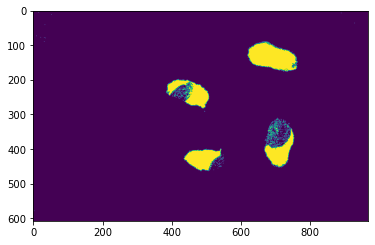

In [106]:
plt.imshow(Mask_test)